In [1]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from sdpa_common import *

In [84]:
xmin, xmax, N = -100*np.pi, 100*np.pi, 65536
g = 1
spectrum = solveTISE(xmin, xmax, N, lambda x: g * (1 - np.cos(x)), 6)

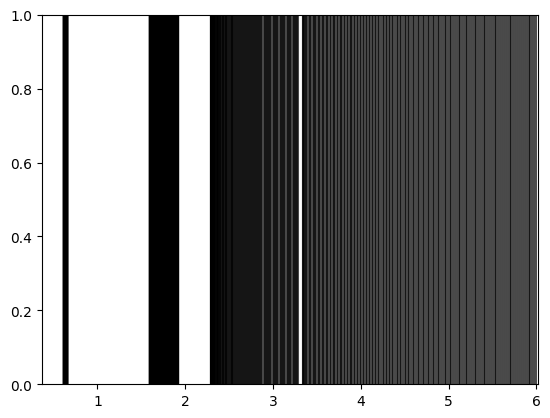

In [85]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,c='black',alpha=0.7,zorder=-2)

In [60]:
class CosineProblem(HankelProblem):
    """
    Solves H = p^2 + 1 - cosx.
    """
    def _initialize_basis(self):
        self._basis = [None, None]
        self._basis[0] = [symbols(f'Ree^i{n}x') for n in range(self._K)]
        self._basis[1] = [symbols(f'Ime^i{n}x') for n in range(self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'Ree^i0x': mp.mpf('1')})
        self._basis[1][0] = self._basis[1][0].subs({'Ime^i0x': mp.mpf('0')})

        # Recursion for <e^inx>
        for t in range(1, len(self._basis[0]) - 1):
            ti = mp.mpf(t)
            self._basis[0][t + 1] = (ti ** 3 - 4 * (self._E - 1) * ti)*self._basis[0][t]
            self._basis[0][t + 1] -= (2 * ti - 1) * self._basis[0][t - 1]
            self._basis[0][t + 1] /= (2 * ti + 1)
            self._basis[1][t + 1] = (ti ** 3 - 4 * (self._E - 1) * ti)*self._basis[1][t]
            self._basis[1][t + 1] -= (2 * ti - 1) * self._basis[1][t - 1]
            self._basis[1][t + 1] /= (2 * ti + 1)
    
    def _generate_internal_matrix_structure(self):
        R = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<Ree^inx>
        C = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<Ime^inx>

        for i in range(self._K):
            for j in range(self._K):
                R[i, j] = self._basis[0][np.abs(j - i)]
                C[i, j] = np.sign(j - i) * self._basis[1][np.abs(j - i)]
        self._internal_matrix = np.block([[R, -C],
                                          [C, R]])

In [66]:
p2 = CosineProblem(14, 'cospot')
p2.initialize_problem()

In [67]:
Es = np.linspace(0, 6, num=200)
ts = solve(p2, Es)

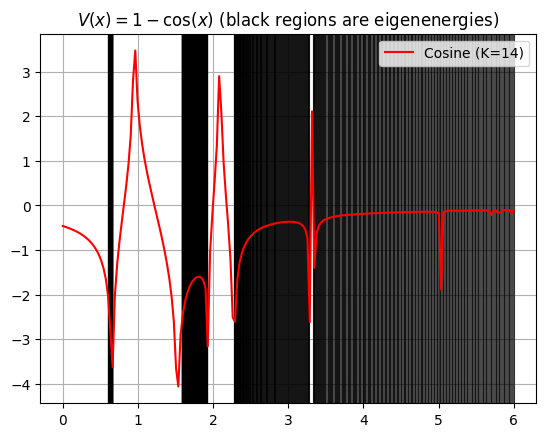

In [86]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,c='black',alpha=0.7,zorder=2)

sns.lineplot(x=Es, y=np.log(np.fabs(ts)), label='Cosine (K=14)',zorder=3,c='red')
plt.grid(zorder=1)
plt.legend()
plt.title(r'$V(x)=1-\cos(x)$ (black regions are eigenenergies)')
plt.show()